# Info

This notebook contains the code for:
- analyzing sequencing data (both WGS and sequence capture) with ANGSD
- generating genetic PCAs

# Setup

Python

In [2]:
## Import some useful functions and data ## 
%run '~/jupyter/py3_functions.py'
%run '~/scripts/polionotus_project/polionotus_setup.py'
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd')

from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

R

In [4]:
%%R
library(tidyverse)
library(magrittr)
library(data.table)
library(ggplot2)
library(gridExtra)
library(wesanderson)
library(RColorBrewer)
library(ggrepel)
library(repr)
library(ape)
library(ggtree)
library(treeio)
setwd("/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd")
hab_colors = wes_palette("Zissou1")[c(1,4)]
names(hab_colors) = c("LO","PO")

# Generate SAF files from bams
Bams are filtered by:
1. mapping quality (>=30)
2. Base quality (>=20)
3. C 50 (higher map Q for excessive mismatches)
4. BAQ 1 (base alignment quality)

## Standard - generate Saf files
Currently running this as unfolded for Ppol, at seqcapture sites ONLY

In [10]:
!mkdir -p seqcap
for pop in ['LO']:
    cmd = ('''~/Software/angsd/angsd -gl 2 -doSaf 1 -fold 0 '''
           '''-minMapQ 30 -minQ 20 -C 50 -baq 1 '''
           '''-anc {ref_genome} ''' 
           '''-ref {ref_genome} '''
           '''-bam {pop}.bamlist.txt '''
           '''-P 16 -rf {seqcap_regions_file} '''
           '''-out seqcap/{pop}\n''').format(seqcap_regions_file=seqcap_regions_file,ref_genome=ref_genome,pop=pop)
    slurm = make_slurm(echo=True,id='%s.bam2saf' % (pop),cmd_string=cmd,mem='40000',time='48:00:00',n=16)

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 48:00:00
#SBATCH --mem=40000
#SBATCH -n 16
#SBATCH --array=1-1%1
#SBATCH -e ./logs/LO.bam2saf.e
#SBATCH -o ./logs/LO.bam2saf.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.bam2saf


~/Software/angsd/angsd -gl 2 -doSaf 1 -fold 0 -minMapQ 30 -minQ 20 -C 50 -baq 1 -anc /n/hoekstra_lab_tier1/Lab/PUBLIC/GENOMES/Ppol1.3_chr_NCBI/Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta -ref /n/hoekstra_lab_tier1/Lab/PUBLIC/GENOMES/Ppol1.3_chr_NCBI/Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta -bam LO.bamlist.txt -P 16 -rf /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_polionotus/lists/all_seqcap.minreads_5_in_minsamples_50.wo_exons_1kb_padding.regions.txt -out seqcap/LO




## Straight to beagle

Now do this for all populations (and Nubiterrae)

In [68]:
!mkdir -p seqcap
cmd = ('''~/Software/angsd/angsd -gl 2 -doGlf 2  -doMajorMinor 1 -doMaf 1 -SNP_pval 1e-6 '''
       '''-bam all.bamlist.txt '''
       '''-nThreads 36 -rf {seqcap_regions_file} -out seqcap/all\n''').format(seqcap_regions_file=seqcap_regions_file)
slurm = make_slurm(run=True,id='all.bam2beagle',cmd_string=cmd,mem='160000',time='72:00:00',n=36)

Submitted batch job 56181347


Run for individual populations, don't bother separating by chromosome

In [6]:
for pop in seqcapture_pops:
    cmd = ('''~/Software/angsd/angsd -gl 2 -doSaf 1 -fold 0 '''
           '''-minMapQ 30 -minQ 20 -C 50 -baq 1 '''
           '''-anc {anc_genome} ''' 
           '''-ref {ref_genome} '''
           '''-bam {pop}.bamlist.txt '''
           '''-P 24 -out bam_based/{pop}\n''').format(pop=pop,ref_genome=ref_genome,anc_genome=anc_genome)
    slurm = make_slurm(run=True,id='%s.bam2saf' % (pop),cmd_string=cmd,mem='40000',time='120:00:00',n=24)

# SFS
## 1D SFS
Get global SFS from each pop

In [71]:
for pop in ['PO','LO']:
    sfs_cmd  = '~/Software/angsd_new/misc/realSFS seqcap/{pop}.saf.idx -P 12 > seqcap/{pop}.global.sfs'.format(pop=pop)
    slurm = make_slurm(run=True,id=('%s.sfs' % pop),cmd_string=sfs_cmd,mem='10000',time='72:00:00',n=12)

Submitted batch job 56239138
Submitted batch job 56239139


## 2D SFS
Pairwise SFS for WGS data

In [30]:
pop1="PO"
pop2="LO"
sfs_cmd = '~/Software/angsd_new/misc/realSFS bam_based/{pop1}.saf.idx bam_based/{pop2}.saf.idx -nSites 10000000 -bootstrap 100 -P 24 > bam_based/{pop1}.{pop2}.boot.sfs'.format(pop1=pop1,pop2=pop2)
slurm = make_slurm(echo=True,id=('%s.%s.sfs' % (pop1,pop2)),cmd_string=sfs_cmd,mem='150000',time='300:00:00',n=24,p='hoekstra,commons')

#!/bin/bash
#SBATCH -p hoekstra,commons
#SBATCH -t 300:00:00
#SBATCH --mem=150000
#SBATCH -n 24
#SBATCH -e ./logs/PO.LO.sfs.e
#SBATCH -o ./logs/PO.LO.sfs.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J PO.LO.sfs

~/Software/angsd_new/misc/realSFS bam_based/PO.saf.idx bam_based/LO.saf.idx -nSites 10000000 -bootstrap 100 -P 24 > bam_based/PO.LO.boot.sfs



Pairwise SFS with sequence capture data

In [78]:
pairwise_combos = list(itertools.combinations(flatten([pops,seqcapture_pops]),2))
for pair in pairwise_combos:
    pop1,pop2 = pair
    sfs_cmd = '~/Software/angsd_new/misc/realSFS seqcap/{pop1}.saf.idx seqcap/{pop2}.saf.idx -P 8 > seqcap/{pop1}.{pop2}.sfs'.format(pop1=pop1,pop2=pop2)
    slurm = make_slurm(echo = True,id=('%s.%s.sfs' % (pop1,pop2)),cmd_string=sfs_cmd,mem='20000',time='100:00:00',n=8,p='hoekstra,shared,commons')

Submitted batch job 56240005
Submitted batch job 56240016
Submitted batch job 56240017
Submitted batch job 56240028
Submitted batch job 56240049
Submitted batch job 56240080
Submitted batch job 56240091
Submitted batch job 56240106
Submitted batch job 56240121
Submitted batch job 56240162
Submitted batch job 56240192
Submitted batch job 56240223
Submitted batch job 56240234


# Get thetas

Again, using unfolded folded approach

First, I want to get a single-line, global SFS as input. I can do this by summing up the multi-line SFS produced by moving in windows of 10e6 sites across the genome

In [29]:
for pop in seqcapture_pops:
    r = np.loadtxt('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd/bam_based/%s.sfs' % pop)
    s = np.sum(r,axis=0)
    np.savetxt('bam_based/%s.single.sfs' % pop,s,newline = " ")

In [4]:
os.chdir('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd/')
for pop in flatten([pops,seqcapture_pops]):
    print(pop)
    if pop not in ['PO','LO']: continue
    thetas_cmd = ('''~/Software/angsd/angsd '''
                  '''-bam {pop}.bamlist.txt '''
                  '''-out seqcap/{pop} '''
                  '''-doThetas 1 '''
                  '''-doSaf 1 '''
                  '''-fold 0 '''
                  '''-pest seqcap/{pop}.global.sfs '''
                  '''-anc {anc_genome} '''
                  ''' -ref {ref_genome} '''
                  '''-GL 2 '''
                  '''-P 12 ''').format(pop=pop,anc_genome=anc_genome,ref_genome=ref_genome)
    slurm = make_slurm(echo=True,id='%s.thetas' % (pop),cmd_string=thetas_cmd,mem='120000',time='167:00:00',n=12)

PO
Submitted batch job 56907294
LO
Submitted batch job 56907298
ABM
CBM
PKBM
POALB
POPOL
POSUB_O
POSUB_A
POSUB_T
SABM
SEBM
SRIBM
NUB


In [12]:
os.chdir('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd/')
for pop in flatten([pops,seqcapture_pops]):
    theta_windows_cmd = ('''~/Software/angsd/misc/thetaStat do_stat '''
                            '''seqcap/{pop}.thetas.idx -win 1000 -step 500 -outnames seqcap/{pop}.theta.window.gz''').format(pop=pop,chrom=chrom)
    slurm = make_slurm(echo=True,id='%s.theta.window' % (pop),cmd_string=theta_windows_cmd,mem='10000',time='00:20:00',p='hoekstra,shared')

Submitted batch job 57546673
Submitted batch job 57546675
Submitted batch job 57546686
Submitted batch job 57546697
Submitted batch job 57546698
Submitted batch job 57546699
Submitted batch job 57546700
Submitted batch job 57546701
Submitted batch job 57546702
Submitted batch job 57546703
Submitted batch job 57546704
Submitted batch job 57546705
Submitted batch job 57546706
Submitted batch job 57546707


Filter windowed results by sequenced regions (it's bullshit that I even need to do this)

In [21]:
p2 = "<(sed 's/:/\\t/;s/-/\\t/' %s)" % seqcap_regions_file
for pop in flatten([pops,seqcapture_pops]):
    FILE = 'seqcap/%s.theta.window.gz.pestPG' % pop
    p1 = ('''<(paste <(awk '{{OFS="\\t"}} {{print $2,$3-1,$3}}' {FILE} | tail -n+2) <(cut -f4- {FILE} | tail -n+2))''').format(FILE=FILE)
    outfile = 'seqcap/%s.theta.regioned' % pop
    cmd = ('''bedtools intersect -wa -wb -a {p1} -b {p2} > {outfile}''').format(p1=p1,p2=p2,outfile=outfile)
    slurm = make_slurm(run=True,id='%s.thetafilter' % pop,cmd_string=cmd,mem='5000',time='00:20:00')

Submitted batch job 57556640
Submitted batch job 57556641
Submitted batch job 57556642
Submitted batch job 57556643
Submitted batch job 57556644
Submitted batch job 57556645
Submitted batch job 57556646
Submitted batch job 57556648
Submitted batch job 57556649
Submitted batch job 57556650
Submitted batch job 57556651
Submitted batch job 57556652
Submitted batch job 57556653
Submitted batch job 57556655


# Fst

With seqcapture data

In [98]:
# The code below assumes that the 2dsfs has already been calculated
pairwise_combos = list(itertools.combinations(flatten([pops,seqcapture_pops]),2))
for pair in pairwise_combos:
    if 'LO' not in pair: continue
    pop1, pop2 = pair
    fst_idx_cmd = ('''~/Software/angsd_new/misc/realSFS fst index '''
               '''seqcap/{pop1}.saf.idx seqcap/{pop2}.saf.idx '''
               '''-sfs seqcap/{pop1}.{pop2}.sfs '''
               '''-fstout seqcap/{pop1}.{pop2}\n''').format(pop1=pop1,pop2=pop2)
    fst_global_cmd = ('''~/Software/angsd_new/misc/realSFS fst stats seqcap/{pop1}.{pop2}.fst.idx > seqcap/{pop1}.{pop2}.fst.global\n''').format(pop1=pop1,pop2=pop2)
    fst_window_cmd = ('''~/Software/angsd_new/misc/realSFS fst stats2 seqcap/{pop1}.{pop2}.fst.idx -win 1000 -step 500 > seqcap/{pop1}.{pop2}.fst.100kwindow\n''').format(pop1=pop1,pop2=pop2)
    full_cmd = fst_idx_cmd + fst_global_cmd + fst_window_cmd
    slurm = make_slurm(echo=True,id=('%s.%s.fst' % (pop1,pop2)),cmd_string=full_cmd,mem='2000',time='01:00:00')

Submitted batch job 56251110
Submitted batch job 56251111
Submitted batch job 56251112
Submitted batch job 56251113
Submitted batch job 56251114
Submitted batch job 56251115
Submitted batch job 56251116
Submitted batch job 56251117
Submitted batch job 56251119
Submitted batch job 56251120
Submitted batch job 56251121
Submitted batch job 56251124
Submitted batch job 56251128


Quick and dirty with vcftools

setup vcf

In [14]:
cmd = ('''module load bcftools vcftools\n'''
       '''bcftools view '''
       '''-T^../beds/agouti_mc1r_cov_bounds.txt '''
       '''-m2 -M2 -v snps '''
       '''../popgen_vcfs/vars/ALL.vcf.gz > ../popgen_vcfs/vars/not_agouti_mc1r.vcf\n'''
       '''/n/home11/twooldridge/scripts/zip_index_vcf.sh ../popgen_vcfs/vars/not_agouti_mc1r.vcf''')
slurm = make_slurm(echo=True,id='filter',cmd_string = cmd,mem='5000',time='00:30:00')

In [11]:
!mkdir -p fst
pairwise_combos = list(itertools.combinations(flatten([pops,seqcapture_pops]),2))
for pair in pairwise_combos:
    pop1,pop2 = pair
    cmd = ('''module load vcftools\n'''
           '''vcftools --gzvcf ../popgen_vcfs/vars/not_agouti_mc1r.vcf.gz '''
           '''--weir-fst-pop ../poplists/{pop1}.poplist.txt --weir-fst-pop ../poplists/{pop2}.poplist.txt '''
           '''--out fst/{pop1}.{pop2} ''').format(pop1=pop1,pop2=pop2)
    slurm = make_slurm(echo=True,id='%s.%s.vcftoolsFST' % (pop1,pop2),cmd_string = cmd,mem='1000',time='00:05:00')

Submitted batch job 55235200
Submitted batch job 55235204
Submitted batch job 55235208
Submitted batch job 55235212
Submitted batch job 55235217
Submitted batch job 55235221
Submitted batch job 55235227
Submitted batch job 55235233
Submitted batch job 55235236
Submitted batch job 55235243
Submitted batch job 55235250
Submitted batch job 55235253
Submitted batch job 55235256
Submitted batch job 55235259
Submitted batch job 55235261
Submitted batch job 55235263
Submitted batch job 55235265
Submitted batch job 55235271
Submitted batch job 55235275
Submitted batch job 55235277
Submitted batch job 55235280
Submitted batch job 55235282
Submitted batch job 55235303
Submitted batch job 55235310
Submitted batch job 55235314
Submitted batch job 55235316
Submitted batch job 55235320
Submitted batch job 55235329
Submitted batch job 55235332
Submitted batch job 55235334
Submitted batch job 55235348
Submitted batch job 55235350
Submitted batch job 55235353
Submitted batch job 55235354
Submitted batc

# PCA

## WGS data only

VCF 2 beagle. Can use the same vcfs I used for SMC

In [15]:
!mkdir -p beagle
vcfs = glob.glob('/n/scratchlfs/hoekstra_lab/brock/polionotus/SMC/vcfs/*vcf.gz')
for vcf in vcfs:
    chrom = os.path.basename(vcf)
    chrom = re.sub(".snps.vcf.gz|PO.|LO.","",chrom)
    outname = re.sub(".vcf.gz","",os.path.basename(vcf))
    cmd =('''module load vcftools\n'''
          '''vcftools --gzvcf {vcf} --chr {chrom} --BEAGLE-PL --out beagle/{outname}\n'''
          '''/n/home11/twooldridge/Software/tabix/bgzip -fc beagle/{outname}.BEAGLE.PL > beagle/{outname}.BEAGLE.PL.gz\n'''
          '''/n/home11/twooldridge/Software/tabix/tabix -f beagle/{outname}.BEAGLE.PL.gz\n''').format(vcf=vcf,chrom=chrom,outname=outname)
    slurm = make_slurm(echo=True,id='%s.2beagle' % os.path.basename(vcf),cmd_string=cmd,mem='5000',time='00:30:00')

Combine beagle files

In [25]:
for grp in ['LO.','PO.','']:
    cat_string = 'cat '
    for chrom in Ppol_sizes.keys():
        if chrom == 'chr1':
            cat_string = cat_string + 'beagle/%s%s.snps.BEAGLE.PL ' % (grp,chrom)
        else:
            cat_string = cat_string + '<(tail -n+2 beagle/%s%s.snps.BEAGLE.PL) ' % (grp,chrom)
    cat_string = cat_string + '> beagle/%ssnps.BEAGLE.PL' % grp
    slurm = make_slurm(id='%sCAT' % grp,cmd_string=cat_string,mem='30000',time='02:00:00')
        

Run pcaangsd

In [32]:
!mkdir -p covar
for grp in ['LO.','PO.','']:
    cmd=('''python2 /n/home11/twooldridge/Software/pcangsd/pcangsd.py '''
         '''-beagle beagle/{grp}snps.BEAGLE.PL.gz -o covar/{grp} -threads 24''').format(grp=grp)
    slurm = make_slurm(run=True,id='%sPCA' % grp,cmd_string=cmd,mem='40000',time='24:00:00',n=24)

Alternative: go straight to beagle files from bam

In [13]:
!mkdir -p bam_based
for pop in pops:
    cmd = ('''~/Software/angsd/angsd -GL 1 -doGlf 2 -doMajorMinor 1 -doMaf 2 -SNP_pval 1e-6 -fold 1 '''
           '''-minMapQ 30 -minQ 20 -C 50 -baq 1 -minHWEpval 0.01 '''
           '''-anc /n/scratchlfs/hoekstra_lab/brock/polionotus/Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta ''' 
           '''-ref /n/scratchlfs/hoekstra_lab/brock/polionotus/Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta '''
           '''-bam /n/scratchlfs/hoekstra_lab/brock/polionotus/poplists/{pop}.bamlist.txt '''
           '''-nThreads 24 -out /n/holylfs/bam_based/{pop}.beagle\n''').format(pop=pop)
    slurm = make_slurm(id='%s.bam2beagle' % (pop),cmd_string=cmd,mem='40000',time='120:00:00',n=24,run=True)

## Including seqcapture data

### Only POALB: ANGSD-produced beagle file

This is a little convoluted, but it is my workaround solution since running ANGSD can sometimes take a while, especially for the albifrons dataset. Because I happened to have a 'beagle' file for albifrons produced for the whole genome (not just seqcapture sites), there were tons of useless sites. So I decided to post-hoc filter this beagle file based on sites that were well-genotyped in the vcf, thinking that it would be quicker/easier then re-running ANGSD with the site restrictions. So here's what I did. **First** get high quality sites:

In [11]:
%%bash
module load bcftools vcftools
bcftools view /n/hoekstra_lab_tier1/Users/brock/polionotus/popgen_vcfs/vars/ALL.vcf.gz -S ../poplists/POALB.poplist.txt | bcftools view -M2 --min-ac 1 -i 'ALT !~ "*"  && STRLEN(REF) == 1 && STRLEN(ALT) == 1'  | vcftools --vcf - --max-missing 0.8 --maf 0.05 --stdout --recode --recode-INFO-all | vcftools --vcf - --hwe 0.001 --kept-sites
mv out.kept.sites POALB_biallelic_maf_missing_sites.txt


VCFtools - 0.1.15

VCFtools - 0.1.15
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf [stdin]
	--max-alleles 2
	--hwe 0.001
	--kept-sites

(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf [stdin]
	--recode-INFO-all
	--maf 0.05
	--max-missing 0.8
	--recode
	--stdout

After filtering, kept 168 out of 168 Individuals
Outputting VCF file...
After filtering, kept 168 out of 168 Individuals
Outputting Kept Sites...
After filtering, kept 4600 out of a possible 22699 Sites
Run Time = 15.00 seconds
After filtering, kept 3977 out of a possible 4600 Sites
Run Time = 15.00 seconds


**Second** read in beagle file and 'good sites' file to do some post-hoc filtering of the POALB beagle

In [2]:
# good sites
goodsites = {}
with open('POALB_biallelic_maf_missing_sites_filtered.txt','r') as data:
    for line in data:
        line = line.strip('\n')
        if 'CHROM' in line: continue
        chrom, pos = line.split('\t')
        if chrom not in goodsites.keys():
            goodsites[chrom] = [pos]
        else:
            goodsites[chrom].append(pos)
data.close()

# Process beagle
newbeagle = []
with open('bam_based/POALB.filtered.beagle','w') as outfile:
    with gzip.open('POALB.beagle.gz','rt') as data:
        for line in data:
            if 'marker' in line: 
                newbeagle.append(line)
                continue
            #line = line.strip('\n')
            ID = line.split('\t')[0]
            Bchrom,Bpos = ID.split('_')
            if Bpos in goodsites[Bchrom]:
                newbeagle.append(line)
                outfile.write(line)
    data.close()
outfile.close()

**Third** Submit PCAangsd job

In [10]:
!mkdir -p covar
cmd=('''python2 /n/home11/twooldridge/Software/pcangsd/pcangsd.py '''
        '''-beagle bam_based/POALB.filtered.beagle.gz -o covar/POALB -threads 16''')
slurm = make_slurm(run=False,id='PCA',cmd_string=cmd,mem='40000',time='02:00:00',n=16)

Vis

Joining, by = "samples"


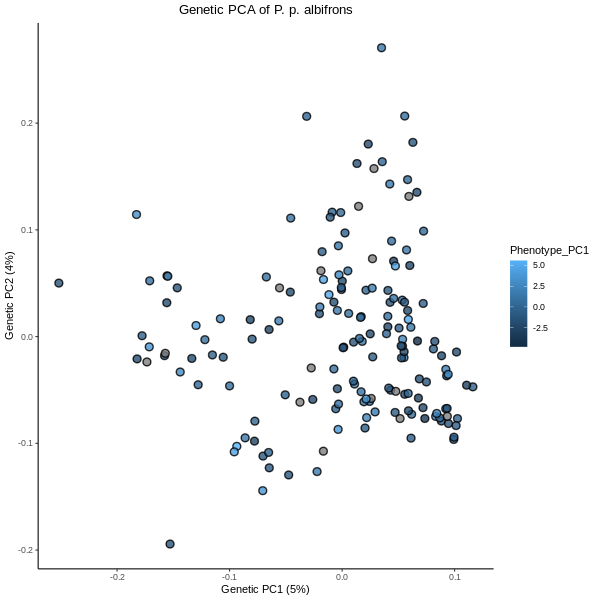

In [14]:
%%R -w 600 -h 600
get_pca = function(covariance_matrix_path){
    mat = read.table(covariance_matrix_path)
    pca = eigen(as.matrix(mat))
    return(pca)
}

get_info = function(sample_list_path,pop_strings,pop_ids){
    info = read.table(sample_list_path) %>% set_colnames("samples")
    info %<>% mutate(pop = NA)
    stopifnot(length(pop_strings)==length(pop_ids))
    for (i in 1:length(pop_strings)){
        cur_string = pop_strings[i]
        cur_id = pop_ids[i]
        info %<>% mutate(pop = ifelse(grepl(cur_string,samples),cur_id,pop))
    }
    return(info)
}

plot_pcs = function(pc_vec=c(1,2),data=pca,inf=info,label=FALSE){
    names = sapply(pc_vec,function(x){paste0("PC",x)})
    comps = data.frame(data$vectors[,pc_vec]) %>% set_colnames(names)
    loads = data$values/sum(data$values)
    loads = sapply(loads[pc_vec],function(x){round(x,2)})
    df = cbind(comps,inf)
    ## Now plot ##
    p = ggplot(df) + 
        geom_point(aes_string(x=names[1],y=names[2],color='pop'),size=3) +
        scale_color_manual(name="",values=hab_colors) +
        xlab(paste0(names[1]," (",loads[1]*100,"%)")) +
        ylab(paste0(names[2]," (",loads[2]*100,"%)")) +
        theme_classic()
    if (label==TRUE){p = p + geom_label_repel(aes_string(label = 'samples',x=names[1],y=names[2]))}
    return(p)
}

ALB_info = get_info('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd/covar/POALB.sample.order.txt',pop_strings = c("POALB"),pop_ids = c("POALB")) %>% mutate(pop="POALB")
ALB_pca = get_pca('/n/hoekstra_lab_tier1/Users/brock/polionotus/angsd/covar/POALB.cov')
pc_vec = c(1,2)
data = ALB_pca
label = FALSE
inf = ALB_info

names = sapply(pc_vec,function(x){paste0("PC",x)})
comps = data.frame(data$vectors[,pc_vec]) %>% set_colnames(names)
loads = data$values/sum(data$values)
loads = sapply(loads[pc_vec],function(x){round(x,2)})
df = cbind(comps,inf)

pheno = fread('/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_polionotus/results/association/pheno_master_miss50perc_withPCA.tsv')
pca_pheno = left_join(df,pheno %>% dplyr::select(ANIMALID,PC1) %>% set_colnames(c("samples","Phenotype_PC1")))


p = ggplot(pca_pheno) + 
    geom_point(aes_string(x=names[1],y=names[2],fill="Phenotype_PC1"),size=3,alpha=0.8,pch=21,stroke=1) +
    xlab(paste0("Genetic ",names[1]," (",loads[1]*100,"%)")) +
    ylab(paste0("Genetic ",names[2]," (",loads[2]*100,"%)")) +
    theme_classic() +
    ggtitle('Genetic PCA of P. p. albifrons') +
    theme(plot.title = element_text(hjust=0.5))
if (label==TRUE){p = p + geom_label_repel(aes_string(label = 'samples',x=names[1],y=names[2]))}

print(p)

#ggsave('~/temp/polionotus/RAWFIGS/albifrons_geneticPCA_phenoPC1.svg',p,height=4,width=6)

### All samples

#### Straight from VCFs

Convert to beagle, then PCAAngsd will be able to use the likelihoods, even if those likelihoods weren't generated by ANGSD proper

In [2]:
!mkdir -p beagle
for chrom in Ppol_sizes.keys():
    cmd =('''module load vcftools\n'''
          '''vcftools --gzvcf /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/popgen_vcfs/vars/ALL.{chrom}.vcf.gz '''
          '''--keep <(cut -f1 ../poplists/wgs_seq_pops_alternate.txt) '''
          '''--exclude ../masks/hwe/seqcap/master.hwe.blacklist.txt '''
          '''--thin 100 '''
          '''--exclude-bed ../phylo/agouti_mc1r.bed --chr {chrom} --BEAGLE-PL --out beagle/{chrom}.ALL\n'''
          '''/n/home11/twooldridge/Software/tabix/bgzip -fc beagle/{chrom}.ALL.BEAGLE.PL > beagle/{chrom}.ALL.BEAGLE.PL.gz\n'''
          '''/n/home11/twooldridge/Software/tabix/tabix -f beagle/{chrom}.ALL.BEAGLE.PL.gz\n''').format(chrom=chrom)
    slurm = make_slurm(run=False,id='%s.2beagle' % chrom,cmd_string=cmd,mem='5000',time='00:30:00')

Submitted batch job 55955954
Submitted batch job 55955955
Submitted batch job 55955956
Submitted batch job 55955957
Submitted batch job 55955959
Submitted batch job 55955960
Submitted batch job 55955961
Submitted batch job 55955963
Submitted batch job 55955965
Submitted batch job 55955966
Submitted batch job 55955970
Submitted batch job 55955971
Submitted batch job 55955972
Submitted batch job 55955973
Submitted batch job 55955975
Submitted batch job 55955977
Submitted batch job 55955978
Submitted batch job 55955979
Submitted batch job 55955980
Submitted batch job 55955981
Submitted batch job 55955982
Submitted batch job 55955983
Submitted batch job 55955984
Submitted batch job 55955985


Combine unzipped beagle files

In [3]:
cat_string = 'cat '
for chrom in Ppol_sizes.keys():
    if chrom == 'chr1':
        cat_string = cat_string + 'beagle/%s.ALL.BEAGLE.PL ' % (chrom)
    else:
        cat_string = cat_string + '<(tail -n+2 beagle/%s.ALL.BEAGLE.PL) ' % (chrom)
cat_string = cat_string + '> beagle/ALL.BEAGLE.PL\n'
zip_cmd = ('''/n/home11/twooldridge/Software/tabix/bgzip -fc beagle/ALL.BEAGLE.PL > beagle/ALL.BEAGLE.PL.gz\n'''
           '''/n/home11/twooldridge/Software/tabix/tabix -f beagle/ALL.BEAGLE.PL.gz\n''').format(chrom=chrom)
slurm = make_slurm(run=True,id='CAT',cmd_string=cat_string+zip_cmd,mem='30000',time='02:00:00')
        

Submitted batch job 55956006


Run PCAangsd -- has several defaults, including maf > 0.05

In [6]:
!mkdir -p covar
cmd=('''python2 /n/home11/twooldridge/Software/pcangsd/pcangsd.py '''
        '''-beagle beagle/ALL.BEAGLE.PL.gz -o covar/all -threads 16''')
slurm = make_slurm(run=True,id='PCA',cmd_string=cmd,mem='40000',time='02:00:00',n=16)

Submitted batch job 54556250


##### Viz

Joining, by = "pop"
Joining, by = "pop"


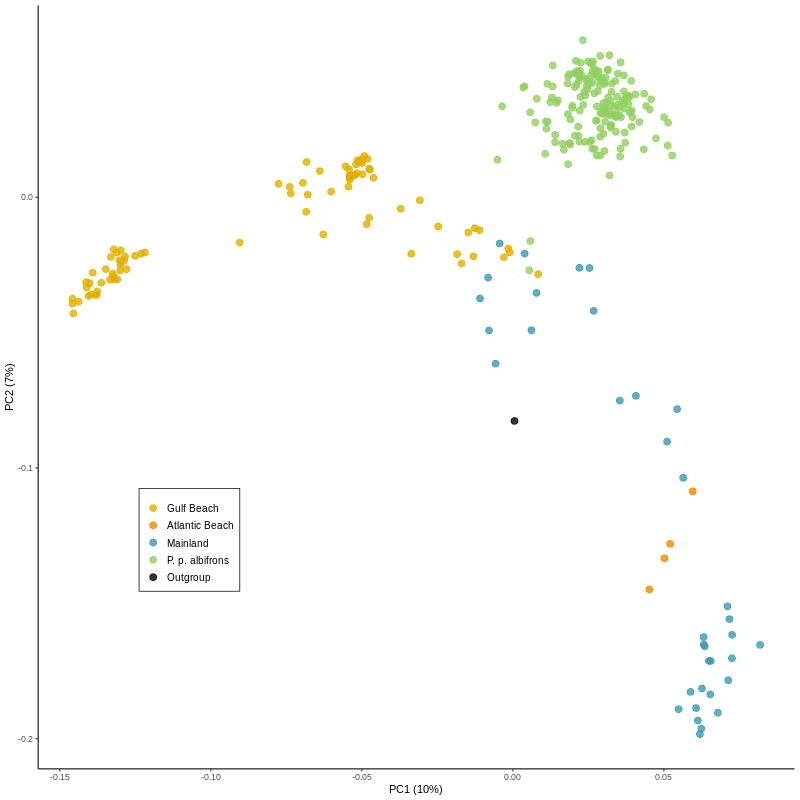

In [7]:
%%R -w 800 -h 800
pop_map = read.table('../polionotus_pop_data.csv',sep=",",header=T)
pop_map %<>% 
    mutate(group = NA) %>%
    mutate(group = ifelse(grepl("PO",pop),"Mainland",group),
           group = ifelse(pop == "SEBM","Atlantic Beach",group),
           group = ifelse(pop == "POALB","P. p. albifrons",group),
           group = ifelse(is.na(group), "Gulf Beach",group),
           group = ifelse(pop == "NUB","Outgroup",group))
pop_map %<>% mutate(seq = ifelse(pop %in% c('PO','LO','NUB'),'WGS','CAP'))

options(repr.plot.width=6,repr.plot.height=4)
pc_vec = c(1,2)
names = sapply(pc_vec,function(x){paste0("PC",x)})
# Setup plottable PC's
mat = read.table("covar/all.cov")
pca = eigen(as.matrix(mat))
comps = data.frame(pca$vectors[,pc_vec]) %>% set_colnames(names)
# Get sample info 
info = read.table("covar/covar_order.txt") %>% set_colnames(c("sample","pop"))
info = left_join(info,pop_map %>% dplyr::select(pop,group)) %>% distinct
# Get loadings
loads = pca$values/sum(pca$values)
loads = sapply(loads[pc_vec],function(x){round(x,2)})
# Combine
df = cbind(comps,info)
df$PC1 = df$PC1 * -1
# Pop labels
labs = df %>%
    group_by(pop) %>%
    summarize(meanPC1 = mean(PC1),meanPC2=mean(PC2)) %>%
    ungroup
labs = left_join(labs, pop_map %>% dplyr::select(pop,sciname)) %>% distinct



# Plot
df$group = factor(df$group, levels = c('Gulf Beach', 'Atlantic Beach', 'Mainland','P. p. albifrons', 'Outgroup'))
p = ggplot(df) + 
    geom_point(aes_string(x=names[1],y=names[2],fill="group", color = 'group'),size=3,pch=21,alpha=0.8) +
    #geom_label_repel(data=labs,aes(x=meanPC1,y=meanPC2,label=sciname),size=3,alpha = 0.8) +
    #geom_point(data=labs,aes(x=meanPC1,y=meanPC2),pch=0) +
    scale_fill_manual(values = c(wes_palette("Zissou1")[c(4)],wes_palette("Darjeeling1")[4], wes_palette("Zissou1")[c(1)],'#91cf60',"black")) +
    scale_colour_manual(values = c(wes_palette("Zissou1")[c(4)],wes_palette("Darjeeling1")[4], wes_palette("Zissou1")[c(1)],'#91cf60',"black")) +    
    xlab(paste0(names[1]," (",loads[1]*100,"%)")) +
    ylab(paste0(names[2]," (",loads[2]*100,"%)")) +
    theme_classic() +
    theme(legend.title = element_blank(),legend.text = element_text(size=10), legend.position = c(0.2,0.3),legend.box.background = element_rect(colour = "black"),legend.background = element_blank())
p
#ggsave('~/temp/polionotus/RAWFIGS/PCA.svg',width = 6,height = 4,p)

#### From ANGSD-produced beagle

Straight from the probabilities generated by running ANGSD on all samples, at seqcapture sites only (see above)

In [15]:
!mkdir -p covar
cmd=('''python2 /n/home11/twooldridge/Software/pcangsd/pcangsd.py '''
        '''-beagle seqcap/all.beagle.gz -o covar/AB_all -threads 16''')
slurm = make_slurm(run=False,id='PCA',cmd_string=cmd,mem='40000',time='24:00:00',n=16)

Viz

In [95]:
%%bash
rm -f covar/AB_all.order.txt
cat all.bamlist.txt | while read path;do ID=$(basename $path | sed 's/\..*//');pop=$(grep "\<$ID\>" ../poplists/wgs_seq_pops_alternate.txt | cut -f2);if [[ $pop == "" ]];then pop=$(grep "$ID" ../poplists/wgs_seq_pops_alternate.txt | cut -f2);fi;echo -e "$ID\t$pop" >> covar/AB_all.order.txt;done

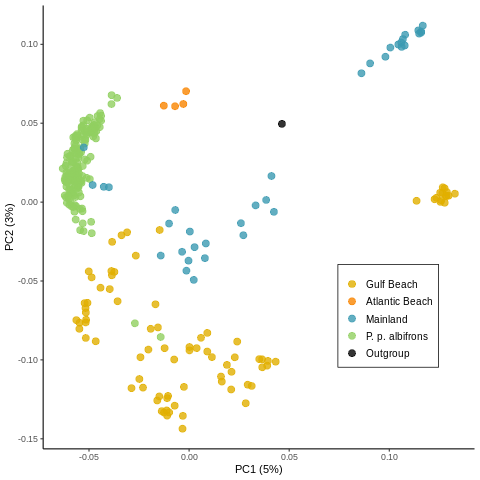

In [28]:
%%R
pc_vec = c(1,2)
names = sapply(pc_vec,function(x){paste0("PC",x)})
# Setup plottable PC's
mat = read.table("covar/AB_all.cov")
pca = eigen(as.matrix(mat))
comps = data.frame(pca$vectors[,pc_vec]) %>% set_colnames(names)
# Get sample info 
info = read.table("covar/AB_all.order.txt") %>% set_colnames(c("sample","pop"))
info = left_join(info,pop_map %>% dplyr::select(altlabel,group), by = c('pop' = 'altlabel')) %>% distinct
# Get loadings
loads = pca$values/sum(pca$values)
loads = sapply(loads[pc_vec],function(x){round(x,2)})
# Combine
df = cbind(comps,info)
df$PC1 = df$PC1 * -1
df$group = factor(df$group, levels = c('Gulf Beach', 'Atlantic Beach', 'Mainland','P. p. albifrons', 'Outgroup'))
# Plot
ggplot(df) + 
    geom_point(aes_string(x=names[1],y=names[2], color='group', fill = 'group'), size=3,pch=21,alpha=0.8) +
    scale_fill_manual(values = c(wes_palette("Zissou1")[c(4)],wes_palette("Darjeeling1")[4], wes_palette("Zissou1")[c(1)],'#91cf60',"black")) +
    scale_colour_manual(values = c(wes_palette("Zissou1")[c(4)],wes_palette("Darjeeling1")[4], wes_palette("Zissou1")[c(1)],'#91cf60',"black")) +    
    xlab(paste0(names[1]," (",loads[1]*100,"%)")) +
    ylab(paste0(names[2]," (",loads[2]*100,"%)")) +
    theme_classic() +
    theme(legend.title = element_blank(),legend.text = element_text(size=10), legend.position = c(0.8,0.3),legend.box.background = element_rect(colour = "black"),legend.background = element_blank())
